In [3]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak


In [5]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle

import numpy as np
import numba

import matplotlib.pyplot as plt

from experiments import utils
from experiments.loss_functions import LogisticRegressionLoss, BaseOracle
from experiments.methods import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

import scipy
import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [6]:
np.random.seed(0)
n = 1000
d = 50
batch_size = 100

data, target = utils.make_synthetic_binary_classification(n, d)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=0)

dataset = train_data, train_target, test_data, test_target

In [ ]:
dataset_name = "a1a"
train_data, train_target = utils.get_libsvm(dataset_name)
train_data = normalize(train_data, norm="l2", axis=1)

In [52]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, f_star=None, suptitle=None, 
            threshold=1e-10, xlims=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
        
    # if f_star is None:
    #     f_star = np.min([x["loss"] for x in histories])
    # else:
    #     f_star = np.min([f_star for x in histories])
    
    for history, label, c, ls, lw, m in zip(histories, labels, colors, linestyles, linewidths, markers):
        # f_suboptim = (history["loss"] - f_star) / (history["loss"][0] - f_star)
        # f_suboptim[f_suboptim < threshold] = 0.0
        
        markevery = [x + np.random.randint(0, 1) for x in range(0, len(history["test/loss"]), len(history["test/loss"]) // 10)]
        
        ax[0].semilogy(history["test/loss"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m)
        ax[1].semilogy(history["test/grad_norm_sq"], linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m)

    if f_star == 0.0:
        ax[0].set_ylabel(r"$f(x_k)$")
        ax[1].set_ylabel(r"$\| f(x_k) \|^2$")
    else:
        ax[0].set_ylabel(r"$(f(x_k) - f^*)/(f(x_0) - f^*)$")
        ax[1].set_ylabel(r"$\| f(x_k) \|^2$")
        
        
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    
    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])

    fig.legend()
    ax[0].grid()
    ax[1].grid()
    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        fig.savefig(filename)
    else:
        fig.show()    

In [86]:
def train_loop(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               optimizer: BaseOptimizer,
               seed: int = 0,
               **optimizer_kwargs) -> dict: 

    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset
    
    # parameters
    params = np.random.randn(train_data.shape[1])
    optim = optimizer(params, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss()
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    for epoch in range(n_epochs):
        
        # Evaluation 
        loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
        g_norm_sq = np.linalg.norm(grad)**2
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)
        
        # Training 
        np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
        
            train_loss, train_grad, _ = loss_function.func_grad_acc(params, batch_data, batch_target)
            
            optim.step(loss=train_loss, grad=train_grad)
            
        # print(f"Epoch [{epoch}/{n_epochs}] | Train Loss: {epoch_loss} | Val Loss: {val_loss}")
        # print(f"Val GradNorm**2: {val_g_norm} | Train GradNorm**2: {epoch_grad_norm}")
        # print(f"Val Acc: {val_acc} | Train Acc: {epoch_acc}\n")
        
        
    # Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    # print(f"Test Loss: {test_loss} | Test Acc: {test_acc} | Test GradNorm**2: {test_g_norm}")
    
    return history

In [93]:
def twin_model(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               seed: int = 0
               ) -> dict: 
    
    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset
    
    # parameters
    params_x = np.random.randn(train_data.shape[1])
    params_y = np.random.randn(train_data.shape[1]) * 10.0

    # oracle 
    loss_function = LogisticRegressionLoss()
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    for epoch in range(n_epochs):
        
        # Evaluation 
        loss, grad, acc = loss_function.func_grad_acc(params_x, test_data, test_target)
        g_norm_sq = np.linalg.norm(grad)**2
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)
        
        print(f"Epoch [{epoch + 1}/{n_epochs}] | {loss=}, {g_norm_sq=}")
        
        # Training 
        np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
        
            train_loss_x, train_grad_x, _ = loss_function.func_grad_acc(params_x, batch_data, batch_target)
            train_loss_y, train_grad_y, _  = loss_function.func_grad_acc(params_y, batch_data, batch_target)
            
            if train_loss_x < train_loss_y:
                params_x, params_y = params_y, params_x
                train_loss_x, train_loss_y = train_loss_y, train_loss_x
                train_grad_x, train_grad_y = train_grad_y, train_grad_x

            # Optimization step
            lr = 2 * ( (train_loss_x - train_loss_y) / (np.linalg.norm(train_grad_x)**2 + 1e-6) )
            params_x -= lr * train_grad_x
            
            history["lr"].append(lr)
            
            
        # print(f"Epoch [{epoch}/{n_epochs}] | Train Loss: {epoch_loss} | Val Loss: {val_loss}")
        # print(f"Val GradNorm**2: {val_g_norm} | Train GradNorm**2: {epoch_grad_norm}")
        # print(f"Val Acc: {val_acc} | Train Acc: {epoch_acc}\n")
        
        
    # Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)

    
    return history

In [88]:
n_epochs = 300
seed = 0

Epoch [1/300] | loss=3.9580764053473927, g_norm_sq=0.4868797620476973
Epoch [2/300] | loss=2.4007050511135857, g_norm_sq=0.08828057953154732
Epoch [3/300] | loss=0.6158187502028327, g_norm_sq=0.026860876962040887
Epoch [4/300] | loss=0.16367255934857702, g_norm_sq=0.020184008629783066
Epoch [5/300] | loss=0.3567065628878692, g_norm_sq=0.02007910659221161
Epoch [6/300] | loss=0.3108729619607994, g_norm_sq=0.017401857772413452
Epoch [7/300] | loss=0.3020417563036567, g_norm_sq=0.017089755648312697
Epoch [8/300] | loss=0.07850189108581147, g_norm_sq=0.005144231644986683
Epoch [9/300] | loss=0.07977612336593388, g_norm_sq=0.00645858142554483
Epoch [10/300] | loss=0.23842426526796406, g_norm_sq=0.012547608312296616
Epoch [11/300] | loss=0.07898020341803688, g_norm_sq=0.0061858230691275535
Epoch [12/300] | loss=0.0739658880227318, g_norm_sq=0.005744780042421508
Epoch [13/300] | loss=0.06562740676692685, g_norm_sq=0.004639671382303764
Epoch [14/300] | loss=0.06463041930150007, g_norm_sq=0.004

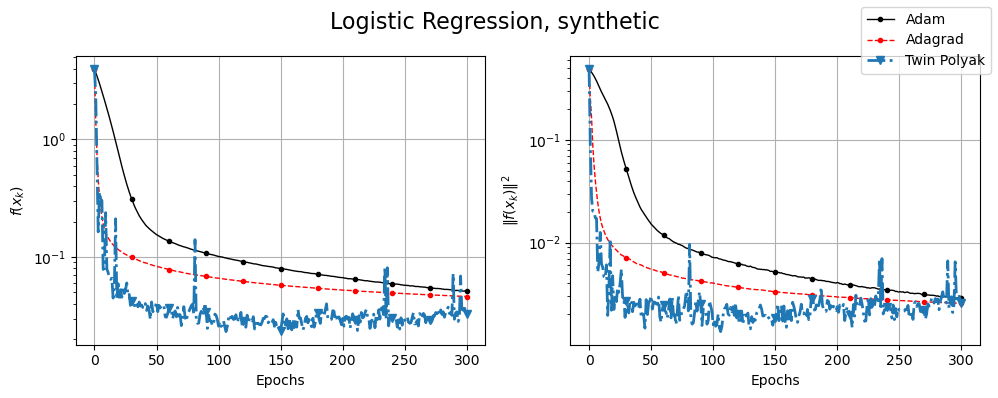

In [94]:
dataset_name = "synthetic"

histories = []
labels = []

hist_adam = train_loop(dataset=dataset, 
                batch_size=batch_size, 
                n_epochs=n_epochs, 
                optimizer=Adam,
                seed=seed, 
                lr=0.01
                )
histories.append(hist_adam)
labels.append("Adam")

hist_adagrad = train_loop(dataset=dataset, 
                batch_size=batch_size, 
                n_epochs=n_epochs, 
                optimizer=Adagrad,
                seed=seed, 
                lr=0.25
                )
histories.append(hist_adagrad)
labels.append("Adagrad")

hist_twin = twin_model(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)
histories.append(hist_twin)
labels.append("Twin Polyak")

plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=[".", ".", "v", "v", "p"],
        f_star=0.0, 
        suptitle=f"Logistic Regression, {dataset_name}",
        threshold=0.0)

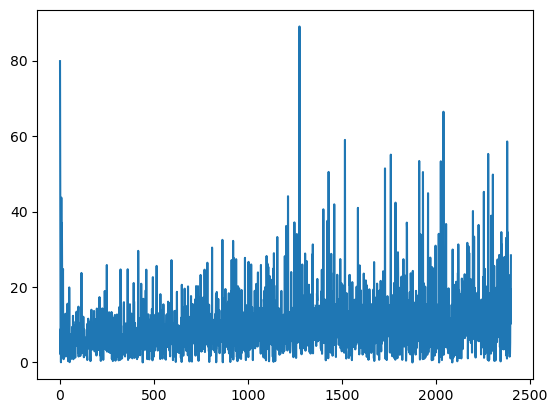

In [95]:
plt.plot(hist_twin["lr"])